In [3]:
import os

for year in [2025, 2030, 2035, 2040]:
    os.environ["PYPSAPL_YEAR"] = str(year)
    %run prepare_input_files.py

Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creating RES & industrial generators...
Creating JWCD, nJWCD, CHP and HPS generators...
Creating load...
All done :>
Creating buses and connections...
Creating CBF buses and links...
Creating PV & Wind capacity factors...
Creatin

In [3]:
%run run_pypsa_lopf.py

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 94.17s
INFO:pypsa.linopf:Solve linear problem using Cplex solver


Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 8 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 6 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 2260080 rows and 6754087 columns.
Aggregator did 630720 substitutions.
Reduced LP has 1436640 rows, 4800480 columns, and 12518006 nonzeros.
Presolve time = 51.27 sec. (9293.34 ticks)
Initializing dual steep norms . . .
Elapsed time = 72.93 sec. (15557.28 ticks, 1 iterations)

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000
Perturbation started.
Iteration:   101   Dual objective     =             0.000000
Iteration:  3995   Dual objective     =             0.000002
Iteration:  7770   Dual objective     =             0.000002
Iteration: 11520   Dual objective     =             0.000002
Iteration: 15369   Dual 

Elapsed time = 1074.11 sec. (316394.40 ticks, 259764 iterations)
Elapsed time = 1090.19 sec. (326407.73 ticks, 260076 iterations)
Iteration: 260299   Dual objective     =    2011860369.630881
Elapsed time = 1106.63 sec. (336417.17 ticks, 260364 iterations)
Elapsed time = 1122.27 sec. (346441.00 ticks, 260676 iterations)
Elapsed time = 1138.16 sec. (356445.51 ticks, 260986 iterations)
Elapsed time = 1153.97 sec. (366460.43 ticks, 261290 iterations)
Elapsed time = 1169.97 sec. (376484.69 ticks, 261590 iterations)
Iteration: 261701   Dual objective     =    2011860369.691939
Elapsed time = 1185.96 sec. (386485.52 ticks, 261876 iterations)
Elapsed time = 1202.05 sec. (396511.66 ticks, 262183 iterations)
Elapsed time = 1218.21 sec. (406516.72 ticks, 262488 iterations)
Elapsed time = 1234.71 sec. (416534.50 ticks, 262790 iterations)
Iteration: 263015   Dual objective     =    2011860369.749970
Elapsed time = 1251.60 sec. (426553.92 ticks, 263072 iterations)
Elapsed time = 1267.66 sec. (43655

Elapsed time = 2992.48 sec. (1358417.98 ticks, 289377 iterations)
Elapsed time = 3008.52 sec. (1368431.02 ticks, 289620 iterations)
Elapsed time = 3025.19 sec. (1378432.75 ticks, 289863 iterations)
Elapsed time = 3041.88 sec. (1388448.23 ticks, 290107 iterations)
Elapsed time = 3059.28 sec. (1398488.59 ticks, 290339 iterations)
Iteration: 290339   Dual objective     =    2011860371.379548
Elapsed time = 3075.48 sec. (1408514.02 ticks, 290586 iterations)
Elapsed time = 3092.27 sec. (1418516.57 ticks, 290832 iterations)
Elapsed time = 3108.98 sec. (1428530.83 ticks, 291075 iterations)
Elapsed time = 3125.93 sec. (1438549.48 ticks, 291318 iterations)
Iteration: 291519   Dual objective     =    2011860371.454620
Elapsed time = 3143.25 sec. (1448549.92 ticks, 291548 iterations)
Elapsed time = 3159.68 sec. (1458571.31 ticks, 291796 iterations)
Elapsed time = 3176.33 sec. (1468584.48 ticks, 292041 iterations)
Elapsed time = 3193.24 sec. (1478621.02 ticks, 292285 iterations)
Elapsed time = 321

INFO:pypsa.linopf:Optimization successful. Objective value: 5.70e+09
INFO:pypsa.io:Exported network network.nc has buses, links, loads, carriers, lines, storage_units, generators


All completed :>


In [63]:
import pandas as pd

def export_capacity_and_production(network):

    df_tech = network.generators.carrier.copy()
    df_tech.name = "Technology"
    for pv_type in ["GROUND", "ROOF"]:
        df_tech[df_tech.index.str.endswith(f"PV_{pv_type}")] = f"PV_{pv_type.capitalize()}"

    df_cap = network.generators.p_nom / 1e3
    df_cap.name = "Installed Capacity [GW]"
    df_cap = pd.merge(df_cap, df_tech, left_index=True, right_index=True, how="left")
    df_cap = df_cap.groupby("Technology").sum()

    df_prod = network.generators_t.p.sum().transpose() / 1e6
    df_prod.name = "Electricity Production [TWh]"
    df_prod = pd.merge(df_prod, df_tech, left_index=True, right_index=True, how="left")
    df_prod = df_prod.groupby("Technology").sum()

    return df_cap, df_prod

def export_marginal_cost(network):

    mc = network.buses_t.marginal_price.mean().transpose().mean() 
    # It should actually be median - otherwise we include the foreign nodes in our calculation!
    df_mc = pd.DataFrame([mc], columns = ["Mean Marginal Cost [PLN/MWh]"])
    return df_mc


In [64]:
import pypsa

from scripts.export_results import export_network_results

for year in [2025, 2030, 2035, 2040]:
    if year != 2040:
        continue
    network = pypsa.Network()
    results_dir = lambda f: f"pypsa/instrat/results/{year}/{f}"
    network.import_from_netcdf(results_dir("network.nc"))
    df_cap, df_prod = export_capacity_and_production(network)
    df_mc = export_marginal_cost(network)
    df_cap.round(decimals=2).to_csv(results_dir("capacity.csv"))
    df_prod.round(decimals=2).to_csv(results_dir("production.csv"))
    df_mc.round(decimals=2).to_csv(results_dir("marginal_cost.csv"), index=False)


INFO:pypsa.io:Imported network network.nc has buses, carriers, generators, lines, links, loads, storage_units


(<matplotlib.collections.PatchCollection at 0x7fce0fb971d0>,
 <matplotlib.collections.LineCollection at 0x7fce0a296cd0>)

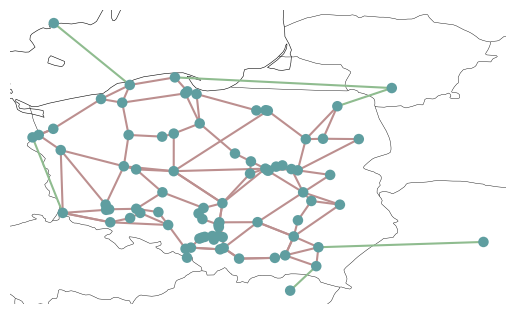

In [9]:
network.plot()